## Notebook for segmenting macrophages and infection context from well plates

**Questions/feedback to Marvin Albert @ IAH (marvin.albert@pasteur.fr)**

Dependencies (additional to other notebook in this repository):
- dask-jobqueue
- distributed


---

### Set input file parameters
- Indicate the input paths in the cell below OR select the paths using the file dialog shown in the second cell:
    - directory containing input images
    - omnipose model file to be used for segmentation
- Outputs will be saved under `<input-dir>/analysis_results`

In [38]:
import os

input_dir = "/pasteur/appa/scratch/maalbert/manina/Revision_NatMicrobiol/20230731_THP-1_Infection_PRIORITY_EXP/"

output_dir = "/pasteur/appa/homes/maalbert/projects/gmanina/automated_segmentation_mycobacterium_tuberculosis_snapshots/macrophage_output"
os.makedirs(output_dir, exist_ok=True)

model_file = "/pasteur/appa/homes/maalbert/projects/gmanina/automated_segmentation_mycobacterium_tuberculosis_snapshots/models/cellpose_residual_on_style_on_concatenation_off_omni_tds_omnipose_laura_maxime_2022_08_25_19_21_43.305437_epoch_9999"

In [1]:
from dask_jobqueue import SLURMCluster
from distributed import Client

cluster = SLURMCluster(
    memory="8GB",
    processes=1,
    cores=8,
    worker_extra_args=['--resources SEG=1'],
)
cluster.adapt(minimum_jobs=0, maximum_jobs=100)

client = Client(cluster)

import os
local_port = 8897
dashboard_port = int(client.dashboard_link.split(':')[2].split('/')[0])

print('\n\n')
print('Command to forward dashboard link:\nssh -NL %s:%s:%s maalbert@maestro.pasteur.fr' %(local_port, 'maestro-submit', dashboard_port))
print('Browser dashboard link:\nhttp://localhost:%s' %local_port)

client





Command to forward dashboard link:
ssh -NL 8897:maestro-submit:8787 maalbert@maestro.pasteur.fr
Browser dashboard link:
http://localhost:8897


<Client: 'tcp://192.168.148.50:45997' processes=0 threads=0, memory=0 B>

In [3]:
# Load modules

import os, sys, copy
import skimage, tifffile
import aicsimageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from tqdm import tqdm
from cellpose import models
from IPython.display import display
from ipyfilechooser import FileChooser

%matplotlib widget

class stdout_suppressor(object):
    def __enter__(self):
        self.stdout = sys.stdout
        sys.stdout = self
    def __exit__(self, type, value, traceback):
        sys.stdout = self.stdout
    def write(self, x): pass

input_dir_c = FileChooser(show_only_dirs=True, select_default=True, title='Choose an input file directory:')
try:
    input_dir_c.default_path = input_dir
except:
    input_dir_c.default_path = os.getcwd()
input_dir_c.reset()

model_file_c = FileChooser(show_only_dirs=False, select_default=True, title='Choose an omnipose segmentation model:')
try:
    model_file_c.default_path = os.path.dirname(model_file)
    model_file_c.default_filename = os.path.basename(model_file)
except:
    model_file_c.default_path = os.getcwd()
model_file_c.reset()

display(input_dir_c)
display(model_file_c)

FileChooser(path='/pasteur/appa/scratch/maalbert/manina/Revision_NatMicrobiol/20230731_THP-1_Infection_PRIORIT…

FileChooser(path='/pasteur/appa/homes/maalbert/projects/gmanina/automated_segmentation_mycobacterium_tuberculo…

Files to be processed:

20230731_THP-1_INH_01_W3_R3D_PRJ.dv
20230731_THP-1_INH_01_W22_R3D_PRJ.dv
20230731_THP-1_INH_01_W10_R3D_PRJ.dv
20230731_THP-1_INH_01_W4_R3D_PRJ.dv
20230731_THP-1_INH_01_W46_R3D_PRJ.dv
20230731_THP-1_INH_01_W33_R3D_PRJ.dv
20230731_THP-1_INH_01_W64_R3D_PRJ.dv
20230731_THP-1_INH_01_W48_R3D_PRJ.dv
20230731_THP-1_INH_01_W92_R3D_PRJ.dv
20230731_THP-1_INH_01_W31_R3D_PRJ.dv
20230731_THP-1_INH_01_W71_R3D_PRJ.dv
20230731_THP-1_INH_01_W59_R3D_PRJ.dv
20230731_THP-1_INH_01_W85_R3D_PRJ.dv
20230731_THP-1_INH_01_W76_R3D_PRJ.dv
20230731_THP-1_INH_01_W39_R3D_PRJ.dv
20230731_THP-1_INH_01_W25_R3D_PRJ.dv
20230731_THP-1_INH_01_W95_R3D_PRJ.dv
20230731_THP-1_INH_01_W18_R3D_PRJ.dv
20230731_THP-1_INH_01_W21_R3D_PRJ.dv
20230731_THP-1_INH_01_W93_R3D_PRJ.dv
20230731_THP-1_INH_01_W6_R3D_PRJ.dv
20230731_THP-1_INH_01_W69_R3D_PRJ.dv
20230731_THP-1_INH_01_W89_R3D_PRJ.dv
20230731_THP-1_INH_01_W65_R3D_PRJ.dv
20230731_THP-1_INH_01_W16_R3D_PRJ.dv
20230731_THP-1_INH_01_W24_R3D_PRJ.dv
20230731_THP-1_IN

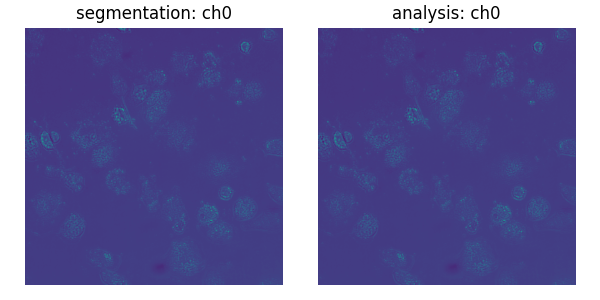

In [5]:
# find files to segment

def recursive_search(file_or_dir, endings=['tif', 'dv']):
    
    fns, fns_m = [], []
    
    if os.path.isdir(file_or_dir):
        for fod in os.listdir(file_or_dir):
            if fod == 'analysis_results': continue
            # print(fod)
            fod = os.path.join(file_or_dir, fod)
            fn, fn_m = recursive_search(fod, endings=endings)
            fns += fn
            fns_m += fn_m
            
    else:
        if max([file_or_dir.endswith(ending) for ending in endings]) and not '_masks' in file_or_dir:
            fns.append(file_or_dir)
                
    return fns, fns_m

input_dir = input_dir_c.selected_path
model_path = model_file_c.selected

fns, fns_m = recursive_search(input_dir, endings=['PRJ.dv'])
print('Files to be processed:\n')
print('\n'.join([os.path.basename(fn) for fn in fns]))
print('\nVisualization of chosen channels:\n')

# The output of this cell lets the user verify
# that the channels have been properly selected

def read_image(fn):
    
    # load first image of the dataset
#     img = tifffile.imread(os.path.join(fn))
    xim = aicsimageio.AICSImage(os.path.join(fn)).xarray_data
    if 'T' in xim.dims:
        xim = xim.sel(T=xim.coords['T'][0])
    if 'Z' in xim.dims:
        xim = xim.max('Z')
                
    return xim

# img = read_image(fns[0])

# fig, axs = plt.subplots(1, 2, figsize=(3*2, 3))
# for ich, ch in enumerate([ch_segmentation, ch_analysis]):
#     ax = axs[ich]
    
#     ax.imshow(img[ch])
#     ax.axis('off')
#     ax.set_title('%s' %(['segmentation: ch%s' %ch_segmentation,
#                          'analysis: ch%s' %ch_analysis][ich]))

# plt.tight_layout()

In [6]:
from skimage.exposure import rescale_intensity  

def normalize(im):
    return rescale_intensity(im,
            in_range=tuple([np.percentile(im, p) for p in [1, 99]]),
            out_range=(0,1))

# tifffile.imshow(
#     np.array([normalize(im) for im in xim]), photometric='la')

In [7]:
import cellpose
from scipy import ndimage

def instance_segmentation_macrophages(xim):
    model = cellpose.models.Cellpose(model_type='cyto2', gpu=True)
    seg = model.eval(xim.sel(C='-50/-50').data[None], channels=[0,0], mask_threshold=0.2, diameter=100)[0]
    return seg

def semantic_segmentation_using_threshold(im, background_sigma):
    # background subtraction
    im_bs = im.astype(float) - ndimage.gaussian_filter(im, sigma=background_sigma)
    im_bs[im_bs<0] = 0

    # smoothing
    im_smooth = ndimage.gaussian_filter(im_bs, sigma=1)

    # determine background mask to determine threshold
    background_mask = im_smooth < np.percentile(im_bs[im_bs>0], 30)

    # threshold
    threshold = np.mean(im_bs[background_mask]) + 10 * np.std(im_bs[background_mask])

    seg = im_smooth > threshold
    return seg

def segment_death_dots(xim):
    # model = cellpose.models.Cellpose(model_type='cyto2', gpu=True)
    # seg = model.eval(xim.sel(C='632/679').data[None], channels=[0,0], mask_threshold=0.5, diameter=100)[1][2] > .5

    im = xim.sel(C='632/679').data
    im = np.array(im)

    return semantic_segmentation_using_threshold(im, background_sigma=20)

def segment_infection(xim):
    
    im = xim.sel(C='575/625').data
    im = np.array(im)

    return semantic_segmentation_using_threshold(im, background_sigma=10)

# xim = read_image(fns[100])

# s = segment_infection(xim)
# tifffile.imshow(np.array([s>0, normalize(xim.sel(C='575/625').data)]), photometric='minisblack')

# s = segment_death_dots(xim)
# tifffile.imshow(np.array([s>0, normalize(xim.sel(C='632/679').data)]), photometric='minisblack')

In [8]:
# im = xim.sel(C='575/625').data
# im = np.array(im)

# # background subtraction
# im_bs = im.astype(float) - ndimage.gaussian_filter(im, sigma=10)
# im_bs[im_bs<0] = 0

# # smoothing
# im_smooth = ndimage.gaussian_filter(im_bs, sigma=1)

# # determine background mask to determine threshold
# background_mask = im_smooth < np.percentile(im_bs[im_bs>0], 30)

# # threshold
# threshold = np.mean(im_bs[background_mask]) + 10 * np.std(im_bs[background_mask])

# seg = im_smooth > threshold

# # seg = ndimage.binary_erosion(seg, iterations=1)
# # seg = ndimage.binary_dilation(seg, iterations=1)

# tifffile.imshow(np.array([seg>0, normalize(im_bs), normalize(xim.sel(C='575/625').data)]), photometric='minisblack')


In [9]:
# extract information from filename using regex

# e.g. 20230731_THP-1_INH_01_W3_R3D_PRJ.dv -> 03 from W3
import re

def extract_well_number(fn):
    return int(re.findall('W(\d+)', os.path.basename(fn))[0])

# extract replicate number from parent folder using regex
def extract_replicate_number(fn):
    return int(re.findall('R(\d+)', os.path.basename(os.path.dirname(fn)))[0])

# def extract_day(fn):
#     return int(re.findall('Day(\d+)', os.path.basename(os.path.dirname(os.path.dirname(fn))))[0])

# extract experimental date using regex. Date is indicated at beginning of filename
# def extract_experiment_date(fn):
#     return re.findall('(\d{7,8})', os.path.basename(fn))[0]
def extract_experiment_id(fn):
    return os.path.basename(os.path.dirname(os.path.dirname(fn)))

# extract cell line using regex, e.g. THP or RAW.
# Restrict to three letter code which appears after eight digit date
# Ignore data
def extract_cell_line(fn):
    # return re.findall('(\d{7,8}_(\w{3}))', os.path.basename(fn))[0][1]
    return os.path.basename(fn).split('_')[1]

# extract drug name using regex, e.g. INH or RIF. Restrict to three letter code
def extract_drug_name(fn):
    # return re.findall('\w{3,5}_(\w{3})', os.path.basename(fn))[0]
    return os.path.basename(fn).split('_')[2]

# fn = fns[200]
# print(fn)
# [func(fn) for func in [extract_well_number, extract_replicate_number, extract_day, extract_experiment_date, extract_drug_name, extract_cell_line]]
[[func(fn) for func in [extract_well_number, extract_replicate_number, extract_experiment_id, extract_drug_name, extract_cell_line]] for fn in fns]

[[3, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [22, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [10, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [4, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [46, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [33, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [64, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [48, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [92, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [31, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [71, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [59, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [85, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [76, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [39, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [25, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [95, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [18, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [21, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [93, 1, '20230731_THP-1_Day0', 'INH', 'THP-1'],
 [6, 1, '20230731_THP-

In [10]:
import pandas as pd
df_fns = pd.DataFrame([
    [fn, os.path.basename(fn)]+[func(fn) for func in
        [extract_well_number,
        extract_replicate_number,
        extract_experiment_id,
        extract_drug_name,
        extract_cell_line]]
        for fn in fns]
    ,
    columns=
        [
            'full_fn',
            'fn',
            'well',
            'replicate',
            'experiment_id',
            'drug',
            'cell_line'
        ]
    )
df_fns

full_fn  \
0    /pasteur/appa/scratch/maalbert/manina/Revision...   
1    /pasteur/appa/scratch/maalbert/manina/Revision...   
2    /pasteur/appa/scratch/maalbert/manina/Revision...   
3    /pasteur/appa/scratch/maalbert/manina/Revision...   
4    /pasteur/appa/scratch/maalbert/manina/Revision...   
..                                                 ...   
763  /pasteur/appa/scratch/maalbert/manina/Revision...   
764  /pasteur/appa/scratch/maalbert/manina/Revision...   
765  /pasteur/appa/scratch/maalbert/manina/Revision...   
766  /pasteur/appa/scratch/maalbert/manina/Revision...   
767  /pasteur/appa/scratch/maalbert/manina/Revision...   

                                       fn  well  replicate  \
0     20230731_THP-1_INH_01_W3_R3D_PRJ.dv     3          1   
1    20230731_THP-1_INH_01_W22_R3D_PRJ.dv    22          1   
2    20230731_THP-1_INH_01_W10_R3D_PRJ.dv    10          1   
3     20230731_THP-1_INH_01_W4_R3D_PRJ.dv     4          1   
4    20230731_THP-1_INH_01_W46_R3D_PRJ.dv    46          1   
..                                    ...   ...        ...   
763   0230804_THW-1_RIF_02_W11_R3D_PRJ.dv    11          2   
764   0230804_THW-1_RIF_02_W12_R3D_PRJ.dv    12          2   
765   0230804_THW-1_RIF_02_W62_R3D_PRJ.dv    62          2   
766   0230804_THW-1_RIF_02_W71_R3D_PRJ.dv    71          2   
767   0230804_THW-1_RIF_02_W47_R3D_PRJ.dv    47          2   

           experiment_id drug cell_line  
0    20230731_THP-1_Day0  INH     THP-1  
1    20230731_THP-1_Day0  INH     THP-1  
2    20230731_THP-1_Day0  INH     THP-1  
3    20230731_THP-1_Day0  INH     THP-1  
4    20230731_THP-1_Day0  INH     THP-1  
..                   ...  ...       ...  
763  20230804_THP-1_Day4  RIF     THW-1  
764  20230804_THP-1_Day4  RIF     THW-1  
765  20230804_THP-1_Day4  RIF     THW-1  
766  20230804_THP-1_Day4  RIF     THW-1  
767  20230804_THP-1_Day4  RIF     THW-1  

[768 rows x 7 columns]

## per file measurements

In [11]:
def segment_file(fn):

    xim = read_image(fn)
    
    # seg_macrophages = segment_macrophages(xim)
    seg_death_dots = segment_death_dots(xim)
    seg_infection = segment_infection(xim)

    # tifffile.imwrite(fn.replace('.dv', '_macrophages.tif'), seg_macrophages.astype(np.uint16))
    tifffile.imwrite(fn.replace('.dv', '_death_dots.tif'), seg_death_dots.astype(np.uint16))
    tifffile.imwrite(fn.replace('.dv', '_infection.tif'), seg_infection.astype(np.uint16))

    return

In [12]:
cluster

SLURMCluster(364c8e5e, 'tcp://192.168.148.50:45997', workers=0, threads=0, memory=0 B)

In [13]:
# fs = client.map(
#     segment_file,
#     fns[:10],
#     resources={'SEG': 1}
#     )

In [14]:
import pandas as pd
from skimage import segmentation, measure

def process_file(fn, df_ms_meta=None):

    xim = read_image(fn)
    seg_macrophages = tifffile.imread(fn.replace('.dv', '_macrophages.tif'))#, seg_macrophages.astype(np.uint16))
    seg_death_dots = tifffile.imread(fn.replace('.dv', '_death_dots.tif'))#, seg_death_dots.astype(np.uint16))
    seg_infection = tifffile.imread(fn.replace('.dv', '_infection.tif'))#, seg_infection.astype(np.uint16))

    # clear borders
    seg_macrophages = segmentation.clear_border(seg_macrophages)

    props_macrophages_infection = measure.regionprops_table(seg_macrophages, intensity_image=seg_infection>0,
        properties=['label', 'area', 'max_intensity', 'intensity_mean', 'centroid'])

    props_macrophages_dead = measure.regionprops_table(seg_macrophages, intensity_image=seg_death_dots>0,
        properties=['label', 'area', 'max_intensity', 'intensity_mean'])
    
    props_macrophages_metabolic_marker = measure.regionprops_table(
        seg_macrophages, intensity_image=seg_infection * xim.sel(C='475/525').data, # only consider pixels in infection mask
        properties=['label', 'area', 'max_intensity', 'intensity_mean'])
    
    props_macrophages_infection_marker = measure.regionprops_table(
        seg_macrophages, intensity_image=xim.sel(C='575/625').data,
        properties=['label', 'area', 'max_intensity', 'intensity_mean'])

    N_ms = len(props_macrophages_infection['label'])
    df_ms = {}
    df_ms['macrophage_label'] = props_macrophages_infection['label']
    df_ms['fn'] = [fn] * N_ms
    df_ms['well'] = [extract_well_number(fn)] * N_ms
    df_ms['replicate'] = [extract_replicate_number(fn)] * N_ms
    df_ms['experiment_id'] = [extract_experiment_id(fn)] * N_ms
    df_ms['drug'] = [extract_drug_name(fn)] * N_ms
    df_ms['cell_line'] = [extract_cell_line(fn)] * N_ms

    df_ms['death_marker_present'] = props_macrophages_dead['max_intensity'] > 0
    df_ms['death_marker_area'] = props_macrophages_dead['area']
    df_ms['death_marker_mean_intensity'] = props_macrophages_dead['intensity_mean']

    df_ms['infection_present'] = props_macrophages_infection['max_intensity'] > 0
    df_ms['infection_area'] = props_macrophages_infection['area']
    df_ms['infection_marker_mean_intensity'] = props_macrophages_infection_marker['intensity_mean']

    df_ms['metablic_marker_mean_intensity'] = props_macrophages_metabolic_marker['intensity_mean']

    # position
    df_ms['x'] = props_macrophages_infection['centroid-0']
    df_ms['y'] = props_macrophages_infection['centroid-1']
    
    df_ms = pd.DataFrame(df_ms)

    if df_ms_meta is not None:
        df_ms = df_ms.astype(df_ms_meta.dtypes)

    return df_ms

# construct empty dataframe with correct column headers and dtypes
df_ms_meta = process_file(fns[0])
df_ms_meta
    

macrophage_label                                                 fn  well  \
0                  3  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
1                  4  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
2                  5  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
3                  6  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
4                  7  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
5                  8  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
6                  9  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
7                 10  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
8                 11  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
9                 12  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
10                13  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
11                14  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
12                15  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
13                16  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
14                17  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
15                20  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
16                21  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
17                22  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
18                23  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
19                24  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
20                26  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
21                27  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
22                28  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
23                29  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
24                30  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
25                31  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
26                32  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
27                33  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
28                34  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
29                35  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
30                36  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
31                38  /pasteur/appa/scratch/maalbert/manina/Revision...     3   

    replicate        experiment_id drug cell_line  death_marker_present  \
0           1  20230731_THP-1_Day0  INH     THP-1                 False   
1           1  20230731_THP-1_Day0  INH     THP-1                 False   
2           1  20230731_THP-1_Day0  INH     THP-1                 False   
3           1  20230731_THP-1_Day0  INH     THP-1                 False   
4           1  20230731_THP-1_Day0  INH     THP-1                 False   
5           1  20230731_THP-1_Day0  INH     THP-1                 False   
6           1  20230731_THP-1_Day0  INH     THP-1                 False   
7           1  20230731_THP-1_Day0  INH     THP-1                 False   
8           1  20230731_THP-1_Day0  INH     THP-1                 False   
9           1  20230731_THP-1_Day0  INH     THP-1                 False   
10          1  20230731_THP-1_Day0  INH     THP-1                  True   
11          1  20230731_THP-1_Day0  INH     THP-1                 False   
12          1  20230731_THP-1_Day0  INH     THP-1                  True   
13          1  20230731_THP-1_Day0  INH     THP-1                 False   
14          1  20230731_THP-1_Day0  INH     THP-1                 False   
15          1  20230731_THP-1_Day0  INH     THP-1                 False   
16          1  20230731_THP-1_Day0  INH     THP-1      

In [21]:
from dask import dataframe as dd
from dask import delayed

df_ms_all_d = dd.concat([dd.from_delayed(delayed(process_file)(fn, df_ms_meta), meta=df_ms_meta) for fn in fns[:]], axis=0)#.compute()#scheduler='processes')
df_ms_all = df_ms_all_d.compute()

In [22]:
df_ms_all

macrophage_label                                                 fn  well  \
0                  3  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
1                  4  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
2                  5  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
3                  6  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
4                  7  /pasteur/appa/scratch/maalbert/manina/Revision...     3   
..               ...                                                ...   ...   
5                  7  /pasteur/appa/scratch/maalbert/manina/Revision...    47   
6                  8  /pasteur/appa/scratch/maalbert/manina/Revision...    47   
7                  9  /pasteur/appa/scratch/maalbert/manina/Revision...    47   
8                 10  /pasteur/appa/scratch/maalbert/manina/Revision...    47   
9                 11  /pasteur/appa/scratch/maalbert/manina/Revision...    47   

    replicate        experiment_id drug cell_line  death_marker_present  \
0           1  20230731_THP-1_Day0  INH     THP-1                 False   
1           1  20230731_THP-1_Day0  INH     THP-1                 False   
2           1  20230731_THP-1_Day0  INH     THP-1                 False   
3           1  20230731_THP-1_Day0  INH     THP-1                 False   
4           1  20230731_THP-1_Day0  INH     THP-1                 False   
..        ...                  ...  ...       ...                   ...   
5           2  20230804_THP-1_Day4  RIF     THW-1                 False   
6           2  20230804_THP-1_Day4  RIF     THW-1                  True   
7           2  20230804_THP-1_Day4  RIF     THW-1                  True   
8           2  20230804_THP-1_Day4  RIF     THW-1                  True   
9           2  20230804_THP-1_Day4  RIF     THW-1                  True   

    death_marker_area  death_marker_mean_intensity  infection_present  \
0                2918                     0.000000              False   
1                9415                     0.000000               True   
2                3518                     0.000000              False   
3                8469                     0.000000              False   
4                5591                     0.000000              False   
..                ...                          ...                ...   
5               11047                     0.000000               True   
6                4110                     0.139903               True   
7               19305                     0.200155               True   
8                7159                     0.000559               True   
9                3865                     0.306080              False   

    infection_area  infection_marker_mean_intensity  \
0             2918                       339.388622   
1             9415                       344.939352   
2             3518                       339.789937   
3             8469                       339.872948   
4             5591                       341.667144   
..             ...                              ...   
5            11047                       486.529918   
6             4110                       470.845255   
7            19305                      1786.301010   
8             7159                      1844.063417   
9             3865                       407.500906   

    metablic_marker_mean_intensity           x           y  
0                         0.000000  109.891364  406.828992  
1                        27.537971  139.948062  628.674243  
2                         0.000000  127.419841  740.122229  
3                         0.000000  198.664423  729.967411  
4                         0.000000  203.052585  518.962797  
..                             ...         ...         ...  
5                       105.760387  355.832896  585.327329  
6                       166.336740  586.990268  336.510949  
7                      1401.948459  740.293

In [25]:
cfile = "/pasteur/appa/scratch/maalbert/manina/Revision_NatMicrobiol/20230731_THP-1_Infection_PRIORITY_EXP/20230731_THP-1_Wells_Correspondence.xlsx"
cdf = pd.read_excel(cfile)
cdf['well'] = cdf['N° image'].apply(lambda x: int(x.split('_W')[-1]))
df_ms_all = pd.merge(df_ms_all, cdf[['MIC M06', 'MIC INH', 'Infection', 'well']], on=['well'])

In [27]:
def plot_plate(plate_df,
               out_dir = os.path.join(output_dir, 'control_images'),
               ):

    exp_id = plate_df['experiment_id'].unique()[0]
    rep = plate_df['replicate'].unique()[0]
    drug = plate_df['drug'].unique()[0]

    # fig = plt.figure(figsize=(8, 12)
    fig_titles = ['macrophages', 'death_dots', 'infection', 'combined']
    figaxss = []
    for _ in fig_titles:
        figaxss.append(plt.subplots(8, 12, figsize=(4*12, 4*8)))

    for wx in tqdm(range(8)[:]):
        for wy in range(12)[:]:
            well = wx*12 + wy + 1
            tmp_df = plate_df[(plate_df['well']==well)]
            # print(well, tmp_df['fn'].unique())

            unique_fns = tmp_df['fn'].unique()
            if not len(unique_fns):
                print('exp_id %s rep %s drug %s: skipping well %s' %(exp_id, rep, drug, well))
                continue

            fn = tmp_df['fn'].unique()[0]
            xim = read_image(fn)

            seg_macrophages = tifffile.imread(fn.replace('.dv', '_macrophages.tif'))#, seg_macrophages.astype(np.uint16))
            seg_macrophages_b = ndimage.binary_dilation(segmentation.find_boundaries(seg_macrophages))

            seg_death_dots = tifffile.imread(fn.replace('.dv', '_death_dots.tif'))#, seg_death_dots.astype(np.uint16))
            seg_death_dots_b = ndimage.binary_dilation(segmentation.find_boundaries(seg_death_dots))

            seg_infection = tifffile.imread(fn.replace('.dv', '_infection.tif'))#, seg_infection.astype(np.uint16))
            seg_infection_b = ndimage.binary_dilation(segmentation.find_boundaries(seg_infection))

            # macrophage segmentation
            axs = figaxss[0][1]
            axs[wx, wy].imshow(np.array(xim[0]), cmap='Greys_r')
            axs[wx, wy].imshow(seg_macrophages_b, alpha=(seg_macrophages_b > 0).astype(float), cmap='Greys_r')

            axs[wx, wy].axis('off')
            axs[wx, wy].set_title('well %s' %well)

            # label macrophage positions
            for ix, row in tmp_df.iterrows():
                axs[wx, wy].text(row['y'], row['x'], '%s' %row['macrophage_label'], color='white')

            # death dots segmentation
            axs = figaxss[1][1]
            axs[wx, wy].imshow(np.array(xim[3]), cmap='Greys_r')
            axs[wx, wy].imshow(seg_death_dots_b, alpha=(seg_death_dots_b > 0).astype(float), cmap='Greys_r')

            axs[wx, wy].axis('off')
            axs[wx, wy].set_title('well %s' %well)

            # infection segmentation
            axs = figaxss[2][1]
            axs[wx, wy].imshow(np.array(xim[2]), cmap='Greys_r')
            axs[wx, wy].imshow(seg_infection_b, alpha=(seg_infection_b > 0).astype(float), cmap='Greys_r')

            axs[wx, wy].axis('off')
            axs[wx, wy].set_title('well %s' %well)

            # combined
            axs = figaxss[3][1]
            # axs[wx, wy].imshow(np.array(xim[0]))
            axs[wx, wy].imshow(seg_macrophages_b, alpha=(seg_macrophages_b > 0).astype(float), cmap='Greys_r', label='macrophages')
            axs[wx, wy].imshow(seg_death_dots_b, alpha=(seg_death_dots_b > 0).astype(float), cmap='Reds', label='death dots')
            axs[wx, wy].imshow(seg_infection_b, alpha=(seg_infection_b > 0).astype(float), cmap='Blues', label='infection')
            # axs[wx, wy].legend()

            axs[wx, wy].axis('off')
            axs[wx, wy].set_title('well %s' %well)

    for ifig, (fig, axs) in tqdm(enumerate(figaxss)):
        out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)
        fig.tight_layout()
        fig.savefig(os.path.join(out_dir, '%s_%s_%s_%s.png' %(exp_id, rep, drug, fig_titles[ifig])))
        # fig.close()

    return

In [28]:
cluster

SLURMCluster(364c8e5e, 'tcp://192.168.148.50:45997', workers=0, threads=0, memory=0 B)

In [31]:
# create control images
from scipy import ndimage
from skimage import segmentation

plt.ioff()

cluster.new_spec['options']['memory'] = '16GB'
cluster.new_worker_spec()

plot_futures = []
for exp_id in df_ms_all['experiment_id'].unique()[:]:
    exp_df = df_ms_all[df_ms_all['experiment_id']==exp_id]
    for rep in exp_df['replicate'].unique()[:]:
        rep_df = exp_df[exp_df['replicate']==rep]
        for drug in rep_df['drug'].unique()[:]:
            drug_df = rep_df[rep_df['drug']==drug]
            
            # plot_plate(drug_df)
            plot_futures.append(client.submit(plot_plate, drug_df, resources={'SEG': 1}))



In [32]:
plot_futures

[<Future: pending, key: plot_plate-00ffec6356cc1703c99dac553459d37a>,
 <Future: pending, key: plot_plate-8b5c4484c8a88f96dee7879d26179308>,
 <Future: pending, key: plot_plate-f0c15ebf09b3bd3a528d9ea4d9845d46>,
 <Future: pending, key: plot_plate-cfc5109045f8620855424a0d6475a3be>,
 <Future: pending, key: plot_plate-e0d41c81e2b6bdb3e9407bf8c756f34e>,
 <Future: pending, key: plot_plate-f52b14fa296f7ca891dd150e888f7909>,
 <Future: pending, key: plot_plate-89ddeda2e399e053e040dccadf6e69be>,
 <Future: pending, key: plot_plate-dc5b6ebcde7a7ce0c7a375a3c8fe000d>]

In [20]:
scheduler = cluster.scheduler

In [ ]:
# for f in plot_futures:
#     f.cancel()

# create output tables

In [33]:
def filter_rows_by_column(df, column, min_value, max_value):
    return df[(df[column] >= min_value) & (df[column] <= max_value)]

filter_rows_by_column(filter_rows_by_column(df_ms_all, 'well', 1, 3), 'macrophage_label', 1, 1)

macrophage_label                                                 fn  \
9693                  1  /pasteur/appa/scratch/maalbert/manina/Revision...   
19128                 1  /pasteur/appa/scratch/maalbert/manina/Revision...   
19146                 1  /pasteur/appa/scratch/maalbert/manina/Revision...   
19160                 1  /pasteur/appa/scratch/maalbert/manina/Revision...   

       well  replicate        experiment_id drug cell_line  \
9693      2          1  20230804_THP-1_Day4  INH     THP-1   
19128     1          2  20230731_THP-1_Day0  RIF     THP-1   
19146     1          2  20230731_THP-1_Day0  INH     THP-1   
19160     1          1  20230804_THP-1_Day4  INH     THP-1   

       death_marker_present  death_marker_area  death_marker_mean_intensity  \
9693                   True               5566                     0.127381   
19128                  True               7303                     0.330823   
19146                 False               3083                     0.000000   
19160                  True               7212                     0.192041   

       infection_present  infection_area  infection_marker_mean_intensity  \
9693                True            5566                       492.457420   
19128              False            7303                       328.156648   
19146              False            3083                       310.121310   
19160               True            7212                      1430.541320   

       metablic_marker_mean_intensity           x           y MIC M06 MIC INH  \
9693                       379.802192   43.919691  594.645706       0       0   
19128                        0.000000   55.392578   82.371902       0       0   
19146                        0.000000  175.736296   93.866364       0       0   
19160                     1831.874099   97.818497  282.150582       0       0   

      Infection  
9693        INF  
19128       INF  
19146       INF  
19160       INF

In [35]:
bys = ['fn', 'experiment_id', 'replicate', 'drug', 'cell_line']
df_files = df_ms_all.groupby(bys).agg(
{
        'macrophage_label': 'count',
        'death_marker_present': 'sum',
        'infection_present': 'sum',
        'infection_area': 'mean',
        'infection_marker_mean_intensity': 'mean',
        'metablic_marker_mean_intensity': 'mean',
    }
)

df_files['ratio_infected'] = df_ms_all.groupby(bys).apply(
    lambda r: (r['infection_present'].sum()/r['macrophage_label'].count()))

df_files['ratio_live'] = df_ms_all.groupby(bys).apply(
    lambda r: ((~r['death_marker_present']).sum()/r['macrophage_label'].count()))

df_files['ratio_live_among_infected'] = df_ms_all.groupby(bys).apply(
    lambda r: (((~r['death_marker_present']) * r['infection_present']).sum()/r['infection_present'].sum()))

df_files['ratio_dead_among_infected'] = df_ms_all.groupby(bys).apply(
    lambda r: (((r['death_marker_present']) * r['infection_present']).sum()/r['infection_present'].sum()))

df_files['ratio_live_among_uninfected'] = df_ms_all.groupby(bys).apply(
    lambda r: (((~r['death_marker_present']) * (~r['infection_present'])).sum()/(~r['infection_present']).sum()))

df_files['ratio_dead_among_uninfected'] = df_ms_all.groupby(bys).apply(
    lambda r: (((r['death_marker_present']) * (~r['infection_present'])).sum()/(~r['infection_present']).sum()))

df_files['ratio_infected_among_live'] = df_ms_all.groupby(bys).apply(
    lambda r: (((~r['death_marker_present']) * r['infection_present']).sum()/(~r['death_marker_present']).sum()))

df_files['ratio_noninfected_among_live'] = df_ms_all.groupby(bys).apply(
    lambda r: (((~r['death_marker_present']) * (~r['infection_present'])).sum()/(~r['death_marker_present']).sum()))

df_files['ratio_infected_among_dead'] = df_ms_all.groupby(bys).apply(
    lambda r: (((r['death_marker_present']) * r['infection_present']).sum()/(r['death_marker_present']).sum()))

df_files['ratio_noninfected_among_dead'] = df_ms_all.groupby(bys).apply(
    lambda r: (((r['death_marker_present']) * (~r['infection_present'])).sum()/(r['death_marker_present']).sum()))

# df_files['fn_base'] = df_files.index.map(lambda x: os.path.basename(x).replace('.dv', ''))

table_output_dir = os.path.join(output_dir, 'tables')
os.makedirs(table_output_dir, exist_ok=True)
df_files.to_csv(os.path.join(table_output_dir, 'results_per_file.csv'))

df_files

/local/scratch/tmp/ipykernel_32480/2712092506.py:20: RuntimeWarning: invalid value encountered in scalar divide
  lambda r: (((~r['death_marker_present']) * r['infection_present']).sum()/r['infection_present'].sum()))
/local/scratch/tmp/ipykernel_32480/2712092506.py:23: RuntimeWarning: invalid value encountered in scalar divide
  lambda r: (((r['death_marker_present']) * r['infection_present']).sum()/r['infection_present'].sum()))
/local/scratch/tmp/ipykernel_32480/2712092506.py:26: RuntimeWarning: invalid value encountered in scalar divide
  lambda r: (((~r['death_marker_present']) * (~r['infection_present'])).sum()/(~r['infection_present']).sum()))
/local/scratch/tmp/ipykernel_32480/2712092506.py:29: RuntimeWarning: invalid value encountered in scalar divide
  lambda r: (((r['death_marker_present']) * (~r['infection_present'])).sum()/(~r['infection_present']).sum()))
/local/scratch/tmp/ipykernel_32480/2712092506.py:32: RuntimeWarning: invalid value encountered in scalar divide
  lamb

macrophage_label  \
fn                                                 experiment_id       replicate drug cell_line                     
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                    32   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                    40   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                    37   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                    36   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                    37   
...                                                                                                           ...   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                    12   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                     9   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                    16   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                    16   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                     2   

                                                                                                 death_marker_present  \
fn                                                 experiment_id       replicate drug cell_line                         
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                         5   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                         5   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                         5   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                         5   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                         2   
...                                                                                                               ...   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                         8   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                         6   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                        15   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                        13   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230804_THP-1_Day4 2         RIF  THW-1                         2   

                                                                                                 infection_present  \
fn                                                 experiment_id       replicate drug cell_line                      
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                     13   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                     15   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                      7   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                      5   
/pasteur/appa/scratch/maalbert/manina/Revision_... 20230731_THP-1_Day0 1         INH  THP-1                      4   
...                                                                                                            ...   
/pasteur/appa/scratch/maalbert/manina/Revision_... 202308

In [36]:
# create dataframe that contains summaries per plate

for exp_id in df_ms_all['experiment_id'].unique():
    exp_df = df_ms_all[df_ms_all['experiment_id']==exp_id]
    for rep in exp_df['replicate'].unique():
        rep_df = exp_df[exp_df['replicate']==rep]
        for drug in rep_df['drug'].unique():
            drug_df = rep_df[rep_df['drug']==drug]
            print(exp_id, rep, drug, len(drug_df['well'].unique()))

            df_plate = drug_df
            df_plate.to_csv(os.path.join(table_output_dir, 'results_per_plate_%s_rep_%s_drug_%s.csv' %(exp_id, rep, drug)))

# df_plates = df_ms_all.groupby(['experiment_id', 'replicate', 'drug']).agg(
# drug_df


20230731_THP-1_Day0 1 INH 96
20230731_THP-1_Day0 1 RIF 96
20230731_THP-1_Day0 2 RIF 96
20230731_THP-1_Day0 2 INH 96
20230804_THP-1_Day4 1 INH 96
20230804_THP-1_Day4 1 RIF 96
20230804_THP-1_Day4 2 INH 96
20230804_THP-1_Day4 2 RIF 96


In [37]:
df_plate

macrophage_label                                                 fn  \
162                   3  /pasteur/appa/scratch/maalbert/manina/Revision...   
163                   5  /pasteur/appa/scratch/maalbert/manina/Revision...   
164                   6  /pasteur/appa/scratch/maalbert/manina/Revision...   
165                   7  /pasteur/appa/scratch/maalbert/manina/Revision...   
166                   8  /pasteur/appa/scratch/maalbert/manina/Revision...   
...                 ...                                                ...   
23505                15  /pasteur/appa/scratch/maalbert/manina/Revision...   
23506                16  /pasteur/appa/scratch/maalbert/manina/Revision...   
23507                17  /pasteur/appa/scratch/maalbert/manina/Revision...   
23508                18  /pasteur/appa/scratch/maalbert/manina/Revision...   
23509                19  /pasteur/appa/scratch/maalbert/manina/Revision...   

       well  replicate        experiment_id drug cell_line  \
162       3          2  20230804_THP-1_Day4  RIF     THW-1   
163       3          2  20230804_THP-1_Day4  RIF     THW-1   
164       3          2  20230804_THP-1_Day4  RIF     THW-1   
165       3          2  20230804_THP-1_Day4  RIF     THW-1   
166       3          2  20230804_THP-1_Day4  RIF     THW-1   
...     ...        ...                  ...  ...       ...   
23505     5          2  20230804_THP-1_Day4  RIF     THW-1   
23506     5          2  20230804_THP-1_Day4  RIF     THW-1   
23507     5          2  20230804_THP-1_Day4  RIF     THW-1   
23508     5          2  20230804_THP-1_Day4  RIF     THW-1   
23509     5          2  20230804_THP-1_Day4  RIF     THW-1   

       death_marker_present  death_marker_area  death_marker_mean_intensity  \
162                   False                657                     0.000000   
163                    True              10871                     0.091068   
164                    True              13058                     0.005897   
165                    True              16781                     0.049342   
166                    True               6462                     0.129681   
...                     ...                ...                          ...   
23505                  True               8318                     0.274946   
23506                  True               3703                     0.246017   
23507                  True               6909                     0.080619   
23508                  True              11518                     0.163223   
23509                  True               7044                     0.536201   

       infection_present  infection_area  infection_marker_mean_intensity  \
162                False             657                       357.808219   
163                 True           10871                       488.487628   
164                 True           13058                       455.992878   
165                 True           16781                       421.700673   
166                 True            6462                       485.539926   
...                  ...             ...                              ...   
23505               True            8318                       492.091849   
23506              False            3703                       393.454226   
23507               True            6909                       522.746852   
23508              False           11518                       393.626498   
23509              False            7044                       402.310193   

       metablic_marker_mean_intensity           x           y MIC M06 MIC INH  \
162                          0.000000   16.547945  742.981735       0      8X   
163                        148.606384  119.965964  188.400423       0      8X   
164                         98.428932  129.480242  772.362000       0      8X   
165                         53.188666  144.724748  442.761039       0      8X   
166                        188.166821  165.584